# Data Cube Cloud Statistics

This notebook explores Landsat-7 and Landsat-8 Data Cubes and reports cloud statistics for selected regions within a cube. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to use a single date when there are no clouds to assess land features.

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Get available products
products_info = dc.list_products()

In [3]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


In [5]:
# Select a Product and a Platform from the tables above

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

In [6]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above
# This region and time period will be used for the cloud assessment

# East Chenene Forest Reserve (Tanzania)
# South-Central Region
# latitude = (-5.762, -5.788)
# longitude = (35.889, 35.931)

# ITISO Region
# latitude = (-5.899, -5.365)
# longitude = (35.665, 36.317)

# PAHI Region
latitude = (-4.966, -4.394)
longitude = (35.783, 36.353)

# Time Period
time_extents = ('2013-01-01', '2014-01-01')

# Cloud Coverage 

In [7]:
import datacube
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 
import numpy as np
from functools import partial  
import pandas as pd

def build_cloud_coverage_table_landsat(product   = None,
                               platform  = None,
                               latitude  = None,
                               longitude = None,
                               time     = None,
                               dc       = None, **kwargs):
    
    if product   is None: raise Exception("product argument is required")
    if platform  is None: raise Exception("platform argument is required")
    if latitude  is None: raise Exception("latitude argument is required")
    if longitude is None: raise Exception("longitude argument is required")
 
    def clean_mask(ds, unpacking_func, bands):
        masks = [unpacking_func(ds, band) for band in bands]
        return np.logical_or(*masks).values
    
    unpack_function = {"LANDSAT_7": ls7_unpack_qa,
                       "LANDSAT_8": ls8_unpack_qa}

    dc = datacube.Datacube(app = "")
    
    load_params = dict(product = product,
                       platform = platform,
                       latitude = latitude,
                       longitude = longitude,
                       measurements = ['pixel_qa'], **kwargs)
    
    if time is not None: 
        load_params["time"] = time
        
    product = dc.load(**load_params)
       
    times  = list(product.time.values)
    scene_slice_list = list(map(lambda t: product.sel(time = t).pixel_qa, times))
    
    clean_mask_list        = list(map(partial(clean_mask, unpacking_func = unpack_function[platform], bands = ["clear", "water"]), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1]), clean_mask_list))
    
    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [8]:
coverage_table = build_cloud_coverage_table_landsat(product = product,
                                   platform = platform,
                                   latitude = latitude,
                                   longitude = longitude,
                                   output_crs = 'EPSG:4326', resolution = (-0.0003, 0.0003),
                                   time = time_extents)

In [9]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2013-04-21 07:45:46.256684,0.575068,2085832
1,2013-04-21 07:46:10.181609,0.046000,166846
2,2013-04-28 07:51:55.403722,0.000000,0
3,2013-05-14 07:52:07.248836,0.000000,0
4,2013-05-23 07:46:25.372645,0.000746,2705
5,2013-05-30 07:52:13.123440,0.000000,0
6,2013-06-08 07:46:00.581521,0.996532,3614528
7,2013-06-08 07:46:24.502209,0.071817,260489
8,2013-06-15 07:52:08.150795,0.000000,0
9,2013-06-24 07:45:54.675552,0.284112,1030506


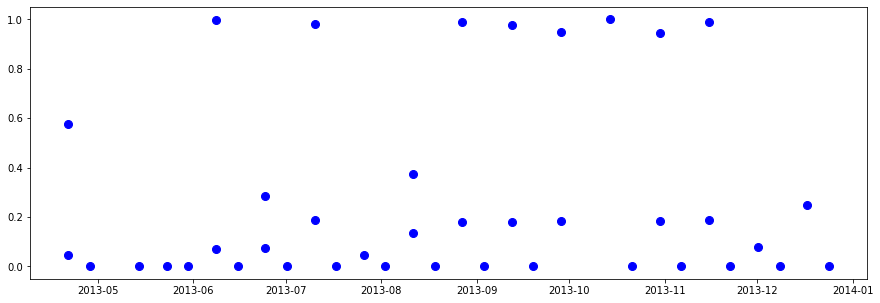

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

## Review an RGB scene for a selected time slice

In [11]:
# Load the data to create an RGB image

landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          output_crs = 'EPSG:4326', resolution = (-0.0003, 0.0003),
                          measurements = ['red', 'green', 'blue']) 

In [12]:
from utils.data_cube_utilities.dc_rgb import rgb

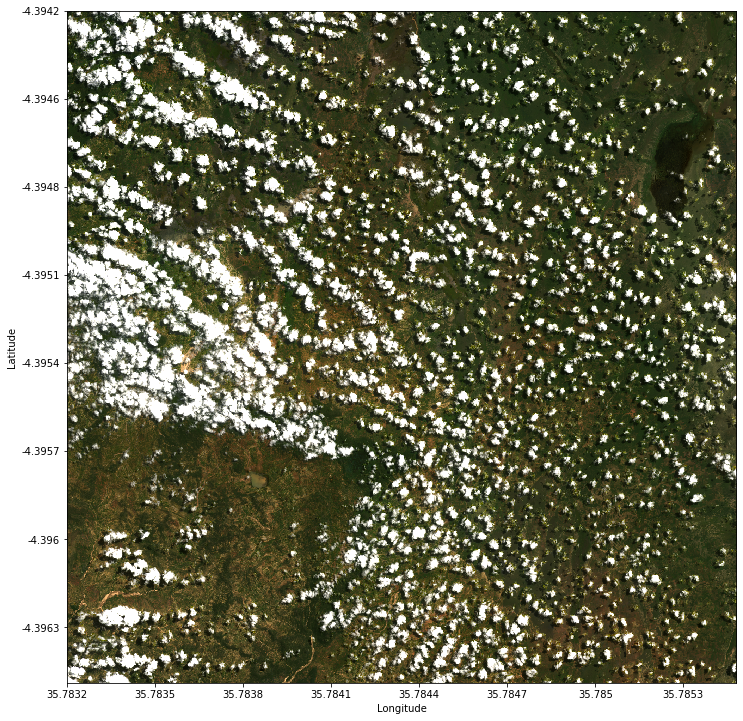

In [13]:
# Select one of the time slices and create an RGB image. 
# Clouds will be visible in WHITE and cloud-shadows will be visible in BLACK
rgb(landsat_dataset, at_index=0, width=12)